# Introduction
## sfl-challenge
Code for the SFL take home challenge and assignment

**Author**: D. Bart Masters (d.bart.masters@gmail.com)

**Time requested**: Saturday, June 8th, 2024 12:00 pm CST

**Time due**: Tuesday, June 11th, 2024 12:00 pm CST

**Audience**: Deloitte-SFL Scientific

This notebook provides a framework to develop a classifier as described in the ReadMe.md and assignment document.

### Contents
- Initial Imports and Paths
- Data Collection and Processing
- Exploratory Data Analysis (EDA)
- Feature engineering and classifier data preparation
- Classifier fitting and evaluation: Classifiers that predict a composer for the labeled data
- Inference on unlabeled data: use the classifier predictions previously to determine which files do NOT belong to the 4 composers in the labeled data

### Files
`composer_class_funcs.py`: supporting file with function definitions used in this notebook. 

---
## Initial Imports and Paths

In [1]:
from composer_class_funcs import *
# ml packages
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

In [2]:
# file paths
train_midi_path = "./Challenge_DataSet/PS1/"
test_midi_path = "./Challenge_DataSet/PS2/"

---
## Data Collection and Processing

In [3]:
# labeled data: creation and pandas dataframe
features, labels = load_dataset(train_midi_path, labeled=True, segments=4)
df_labeled = create_dataframe(features, labels)

In [4]:
# unlabeled data: creation and pandas dataframe
# by specifying "labeled=False" this call will only produce 1 record per file, with the first 30 seconds of the file.
unlabeled_features = load_dataset(test_midi_path, labeled=False)
df_unlabeled=create_dataframe(unlabeled_features)

In [5]:
# define numeric columns for later analysis
numeric_columns = df_labeled.select_dtypes(include=['float64', 'int64']).columns

---
## EDA

In [ ]:
# Display basic information about the labeled data
print("\nBasic Information about the DataFrame:")
print(df_labeled.info())

# Generate summary statistics
print("\nSummary Statistics of the DataFrame:")
print(df_labeled.describe())

# Check for missing values
print("\nMissing Values in the DataFrame:")
print(df_labeled.isnull().sum())

In [ ]:
# filenames
print('Labeled Files: ',df_labeled['filename'].unique().shape[0])
print('Unlabeled Files: ',df_unlabeled['filename'].unique().shape[0])

In [ ]:
# confirm they're all type 1: 
## https://mido.readthedocs.io/en/latest/files/midi.html#file-types
## type 1 (synchronous): all tracks start at the same time
print(df_labeled.type.value_counts())
print(df_unlabeled.type.value_counts())

In [ ]:
# see some unique values of the key
df_labeled.key.value_counts()

In [ ]:
# Visualize the distribution of each numeric feature
plt.figure(figsize=(20, 15))
for i, col in enumerate(numeric_columns):
    plt.subplot(10, 14, i+1)
    sns.histplot(df_labeled[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

In [ ]:
# Visualize the distribution of each numeric feature for the unlabeled data to see if it's similar

plt.figure(figsize=(20, 15))
for i, col in enumerate(numeric_columns):
    plt.subplot(10, 14, i+1)
    sns.histplot(df_unlabeled[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

### Conclusion:
based on this, I'd remove notes 0-22, 105-127.
The unlabeled dataset also has no info for these notes.
See feature engineering and prep section for removal.

In [ ]:
## Commented out as this is not particularly useful
# Visualize correlations between numeric features

# plt.figure(figsize=(12, 10))
# correlation_matrix = df_labeled[numeric_columns].corr()
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
# plt.title('Correlation Matrix')
# plt.show()


In [ ]:
# Visualize the relationship between the first 3 numeric features and the target (if applicable)
if 'composer' in df_labeled.columns:
    for i in range(1,4):
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='composer', y=numeric_columns[i], data=df_labeled, hue='composer')
        plt.title(f'{numeric_columns[i]} by Composer')
        plt.show()

In [ ]:
# Prepare the data for the stacked bar chart
key_composer_counts = df_labeled.groupby(['key', 'composer']).size().unstack(fill_value=0)
# Plot the stacked bar chart
key_composer_counts.plot(kind='bar', stacked=True, figsize=(14, 7), colormap='viridis')
plt.title('Number of Records per Key, Colored by Composer')
plt.xlabel('Key')
plt.ylabel('Number of Songs')
plt.xticks(rotation=90)
plt.legend(title='Composer')
plt.show()

---
## Clean + Feature Engineer

In [6]:
# Drop columns corresponding to notes 0-22 and 105-127 based on EDA
cols_to_drop = [f'Note_{i}' for i in list(range(0, 23)) + list(range(105, 128))]
df_labeled.drop(columns=cols_to_drop, inplace=True)
df_unlabeled.drop(columns=cols_to_drop, inplace=True)

In [7]:
# replace Null keys with 'unk' value
df_labeled['key']=df_labeled['key'].fillna('unk')
df_unlabeled['key']=df_unlabeled['key'].fillna('unk')

# Encode the 'key' variable
label_encoder_key = LabelEncoder()
label_encoder_key.fit(df_labeled['key'].unique().tolist()+df_unlabeled['key'].unique().tolist())
df_labeled['key_encoded'] = label_encoder_key.transform(df_labeled['key'])
df_unlabeled['key_encoded'] = label_encoder_key.transform(df_unlabeled['key'])

# Encode the 'Composer' column: for labeled data only
label_encoder_composer = LabelEncoder()
df_labeled['composer'] = label_encoder_composer.fit_transform(df_labeled['composer'])

In [8]:
# Define the features (X) and target (y)
X = df_labeled.drop(columns=['composer', 'filename','key'])
y = df_labeled['composer']

# Define features for unlabeled data
z = df_unlabeled.drop(columns=['filename','key'])

In [9]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [10]:
# view label distributions
print(label_encoder_composer.classes_,'\n')
print('train targets\n',y_train.value_counts())
print('\ntest targets\n',y_test.value_counts())

['Bach' 'Beethoven' 'Brahms' 'Schubert'] 

train targets
 composer
1    313
3     62
2     47
0     43
Name: count, dtype: int64

test targets
 composer
1    215
3     38
2     33
0     25
Name: count, dtype: int64


---
## Train Classifiers

### Logistic Regression

In [ ]:
# Train and evaluate the Logistic Regression model
log_reg = LogisticRegression(max_iter=10000, random_state=42)
log_reg.fit(X_train, y_train)
# predictions
y_pred_test_lr = log_reg.predict(X_test)
y_pred_train_lr = log_reg.predict(X_train)
# Get the classification probabilities for each class for test dataset
y_proba_test_lr = log_reg.predict_proba(X_test)
y_proba_train_lr = log_reg.predict_proba(X_train)

In [ ]:
model_eval("Logistic Regression", y_train, y_pred_train_lr, y_proba_train_lr, y_test, y_pred_test_lr, y_proba_test_lr, label_encoder_composer)

### SVM

In [ ]:
# Build and train the Random Forest classifier
svm_classifier = LinearSVC(penalty='l2', random_state=0, tol=1e-5)
# Wrap the LinearSVC classifier with CalibratedClassifierCV to obtain probabilities
calibrated_svc = CalibratedClassifierCV(estimator=svm_classifier, method='sigmoid')
calibrated_svc.fit(X_train, y_train)
# predictions
y_pred_test_svc = calibrated_svc.predict(X_test)
y_pred_train_svc = calibrated_svc.predict(X_train)
# Get the classification probabilities for each class for test dataset
y_proba_test_svc = calibrated_svc.predict_proba(X_test)
y_proba_train_svc = calibrated_svc.predict_proba(X_train)

In [ ]:
model_eval("Support Vector Machine (CV Calibrated)", y_train, y_pred_train_svc, y_proba_train_svc, y_test, y_pred_test_svc, y_proba_test_svc, label_encoder_composer)

### Random Forest

In [ ]:
# Build and train the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)
# predictions
y_pred_test_rf = rf_classifier.predict(X_test)
y_pred_train_rf = rf_classifier.predict(X_train)
# Get the classification probabilities for each class for test dataset
y_proba_test_rf = rf_classifier.predict_proba(X_test)
y_proba_train_rf = rf_classifier.predict_proba(X_train)

In [ ]:
model_eval("Random Forest", y_train, y_pred_train_rf, y_proba_train_rf, y_test, y_pred_test_rf, y_proba_test_rf, label_encoder_composer)

### GBM

In [11]:
# Build and train the Random Forest classifier
gb_classifier = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_classifier.fit(X_train, y_train)

# predictions
y_pred_test_gb = gb_classifier.predict(X_test)
y_pred_train_gb = gb_classifier.predict(X_train)
# Get the classification probabilities for each class for test dataset
y_proba_test_gb = gb_classifier.predict_proba(X_test)
y_proba_train_gb = gb_classifier.predict_proba(X_train)

GBM :
AUC for Training Set: 1.0000
AUC for Test Set: 0.9509
Accuracy Score (Test): 0.8971061093247589

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.74      0.92      0.82        25
           1       0.95      0.93      0.94       215
           2       0.71      0.67      0.69        33
           3       0.89      0.87      0.88        38

    accuracy                           0.90       311
   macro avg       0.82      0.85      0.83       311
weighted avg       0.90      0.90      0.90       311



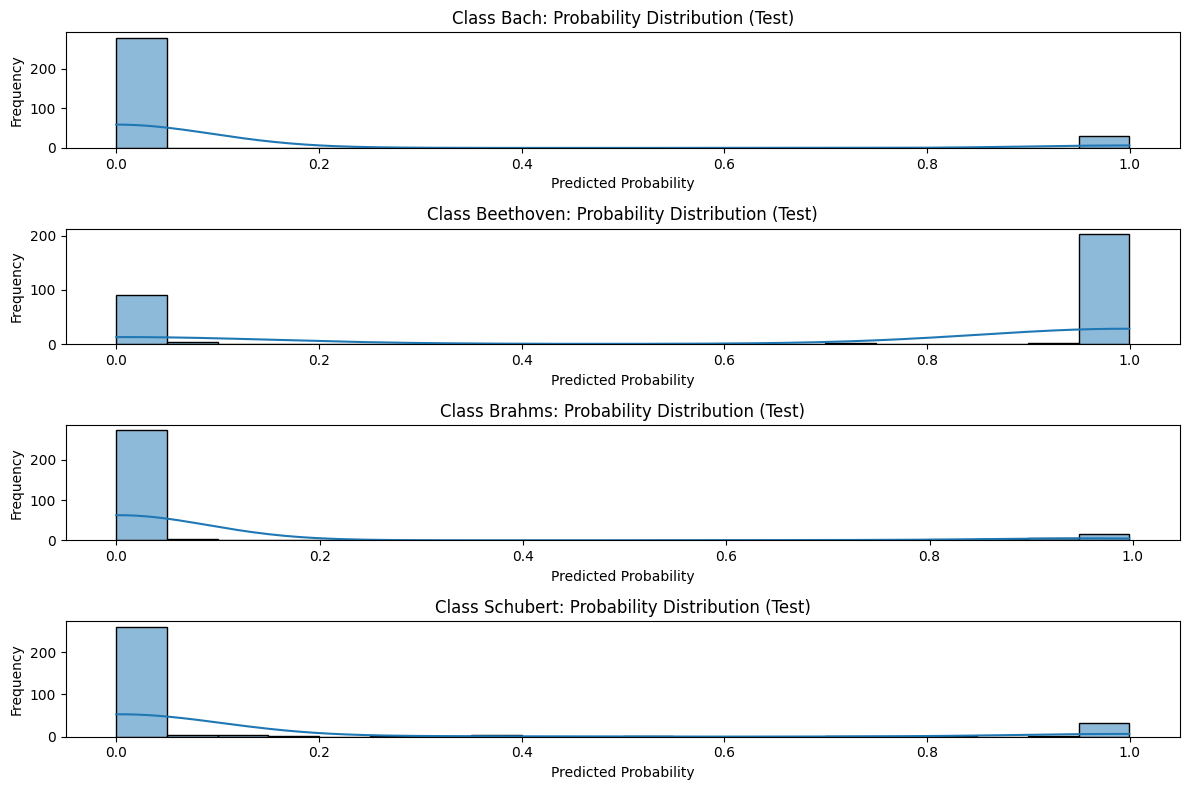

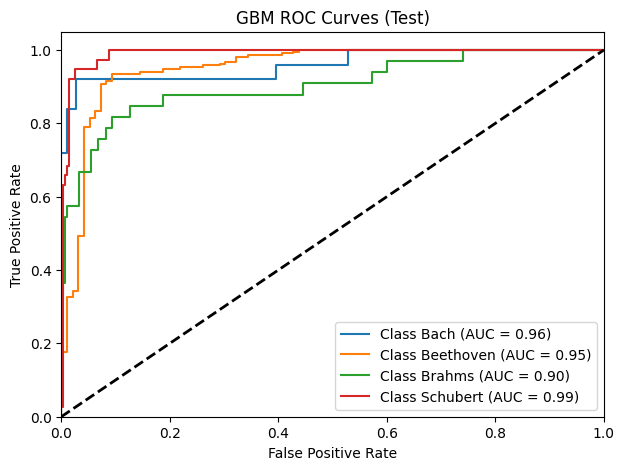

In [12]:
model_eval("GBM", y_train, y_pred_train_gb, y_proba_train_gb, y_test, y_pred_test_gb, y_proba_test_gb, label_encoder_composer)

Top 10 feature importances:
tpb: 0.518686217060297
average_velocity: 0.25869092658087267
key_encoded: 0.03985929903524551
Note_41: 0.0196498770633094
Note_34: 0.01844594048827226
Note_38: 0.014130945531801225
variance_velocity: 0.014031276234829223
Note_30: 0.013493519814581254
Note_33: 0.008009093099753315
Note_61: 0.007467681141092524


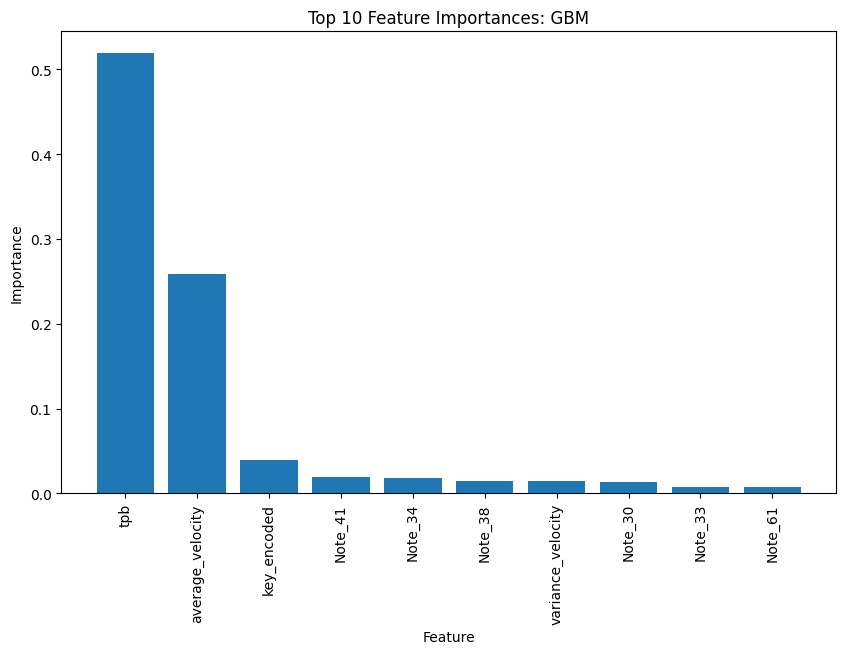

In [13]:
gbm_importances = top_feat(gb_classifier, "GBM", X_train, n=10)

## Inference: Unlabeled
### Method:
- Choose the GBM classifier based on performance and scalability
- For each class, take the maximum predicted probability for the record that corresponds to the predicted composer. 
Hypothesis: those files with the lowest max. predicted probability are likely to not belong to any of the classes in the training set.
Examine the distribution of the maximum probability and choose a threshold, below which we predict that a file does not belong to any of our labeled classes.

Knowing that there are "not many" we can guess at what might be a decent threshold. Further testing would require more labeling of files that are know to not belong to any of our 4 labeled composers.

In [ ]:
# Predict the target on the unlabeled set
y_pred_unlabeled = gb_classifier.predict(z)
# Get the classification probabilities for each class
y_proba_unlabeled = gb_classifier.predict_proba(z)

In [ ]:
print(label_encoder_composer.inverse_transform(y_pred_unlabeled))

In [ ]:
# Plot histogram of the maximum probabilities for each file, and color by predicted composer

# Prepare the data for plotting
df_plot = pd.DataFrame(y_proba_unlabeled, columns=[f'Class_{i}_prob' for i in range(y_proba_unlabeled.shape[1])])
df_plot['Predicted_Class'] = y_pred_unlabeled
df_plot['Predicted Composer'] = label_encoder_composer.inverse_transform(y_pred_unlabeled)

# Extract the highest predicted probability for each record
df_plot['Max_Probability'] = df_plot[[f'Class_{i}_prob' for i in range(y_proba_unlabeled.shape[1])]].max(axis=1)

# Plot the histogram
plt.figure(figsize=(12, 8))
sns.histplot(data=df_plot, x='Max_Probability', hue='Predicted Composer', multiple='stack', palette='tab10', bins=20)
plt.title('Histogram of Predicted Probabilities by Class')
plt.xlabel('Predicted Probability')
plt.ylabel('Number of Records')
plt.tight_layout()
plt.show()

Based on this histogram, we can select a probability threshold such that
```
if max(predicted probability for all classes) < threshold
then midi file is NOT one of the 4 composers in training data
````
To begin, I'd select a threshold of 0.91, resulting in 3 out of the 35 midi files being classified as NOT belonging to our 4 known composers.

In [ ]:
final_threshold_p = 0.91

In [ ]:
final_output= df_unlabeled[['filename']].merge(df_plot[df_plot.Max_Probability<final_threshold_p],left_index=True, right_index=True, how = 'right').drop(
    labels=['Predicted_Class','Predicted Composer'], axis=1)

In [ ]:
# Create final output of files we believe to not belong to any of our 4 composers
print(final_output['filename'])
final_output['filename'].to_csv('Identified_files.csv')

The following files are predicted to NOT belong to the 4 composers in our labeled dataset based on the methods employed above.

0.8014751784512073_adj.mid

0.3559970176888735_adj.mid

0.1960551158929671_adj.mid